In [2]:
!pip install --upgrade gensim

In [3]:
import pandas as pd
import numpy as np
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
import torch
import torch.nn as nn
import nltk
import string
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import KFold

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
training_df = pd.read_csv('TREC_train.csv')[['text', 'label-coarse']]
test_df = pd.read_csv('TREC_test.csv')[['text', 'label-coarse']]

# Remove duplicates
training_df = training_df.drop_duplicates()
test_df = test_df.drop_duplicates()

def word_to_index(data):
  tokens = [word_tokenize(sentence) for sentence in data]
  word_index = {}  # Create an empty dictionary for word-to-index mapping
  current_index = 0

  for sentence in tokens:
    for word in sentence:
      if word in string.punctuation:
        pass
      word = word.lower()
      if word not in word_index:
        word_index[word] = current_index
        current_index += 1
  return word_index

total_df = pd.concat([training_df, test_df])
word_index = word_to_index(total_df['text'].values)

# Merge label-coarse 2 & 5 into 4 (OTHERS)
training_df.loc[(training_df['label-coarse'] == 2), 'label-coarse'] = 5
training_df.loc[training_df['label-coarse'] == 3, 'label-coarse'] = 2
training_df.loc[training_df['label-coarse'] == 4, 'label-coarse'] = 3
training_df.loc[training_df['label-coarse'] == 5, 'label-coarse'] = 4
# print(training_df['label-coarse'].value_counts())

test_df.loc[test_df['label-coarse'] == 2, 'label-coarse'] = 5
test_df.loc[test_df['label-coarse'] == 3, 'label-coarse'] = 2
test_df.loc[test_df['label-coarse'] == 4, 'label-coarse'] = 3
test_df.loc[test_df['label-coarse'] == 5, 'label-coarse'] = 4
# print(test_df['label-coarse'].value_counts())

train_df, val_df = train_test_split(training_df, test_size=500, random_state=42)

In [6]:
w2v = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [7]:
# Early Stopping mechanism
class EarlyStopping:
    def __init__(self, patience=3, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_acc):
        if self.best_score is None:
            self.best_score = val_acc
        elif val_acc < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_acc
            self.counter = 0

        return self.early_stop

In [8]:
# Tokenize
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.nn.utils.rnn import pad_sequence

class CustomDataset(Dataset):
    def __init__(self, X, y):
      self.X =torch.tensor(X)
      self.y =torch.tensor(y)

    def __len__(self):
      return len(self.y)

    def __getitem__(self,idx):
      return self.X[idx], self.y[idx]

max_length = 15
def word2vec(data, word_to_index, padding=False):
  tokens = [word_tokenize(sentence) for sentence in data]
  vectors = []

  for sentence in tokens:
    v = []
    for word in sentence:
      if word in string.punctuation:
        continue
      v.append(word_to_index[word.lower()])
    vectors.append(v)
  if padding:
    padding = [0]
    for i in range(len(vectors)):
      v = vectors[i]
      # Padding
      if len(v) < max_length:
        pad_length = max_length - len(v)
        v.extend(padding * pad_length)
        torch.tensor(v)
      # Truncating
      else:
        vectors[i] = v[:max_length]
        torch.tensor(vectors[i])

  return vectors

X_train = word2vec(train_df['text'].values, word_index, padding=True)
X_val = word2vec(val_df['text'].values, word_index, padding=True)
X_test = word2vec(test_df['text'].values, word_index, padding=True)

train_dataset = CustomDataset(X_train, train_df['label-coarse'].values)
val_dataset = CustomDataset(X_val, val_df['label-coarse'].values)
test_dataset = CustomDataset(X_test, test_df['label-coarse'].values)

batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
# Generate Embedding matrix
vocab_size = len(word_index)
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in w2v:
        embedding_matrix[i] = w2v[word]
    else:
        embedding_matrix[i] = np.random.uniform(-0.25, 0.25, embedding_dim) # random initialization

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim, output_dim, aggregation_method="Last Time Step"):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional=True)
        '''if bidirectional=True'''
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(2*hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)
        self.aggregation_method = aggregation_method

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        if self.aggregation_method == "Last Time Step":
          x = self.dropout(x[:, -1, :])
        elif self.aggregation_method == "Mean Pooling":
          x = torch.mean(x, dim=1)
        x = self.fc(x)
        output = self.softmax(x)
        return output

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (torch.argmax(pred, dim=1) == y).sum().item()

    train_loss /= num_batches
    train_correct /= size

    return train_loss, train_correct

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_correct = 0, 0
    pred_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            pred_label_batch = torch.argmax(pred, dim=1)
            test_loss += loss_fn(pred, y).item()
            test_correct += (torch.argmax(pred, dim=1) == y).sum().item()
            pred_labels.extend(pred_label_batch.numpy())

    test_loss /= num_batches
    test_correct /= size

    return test_loss, test_correct, pred_labels

def validation_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += (torch.argmax(pred, dim=1) == y).sum().item()

    test_loss /= num_batches
    test_correct /= size

    return test_loss, test_correct

def fit(model, optimizer, loss_fn, train_dataloader, val_dataloader, epochs, verbose):
    earlyStopping = EarlyStopping()
    # Used for plotting later on
    train_loss_list, validation_loss_list = [], []
    train_acc_list, validation_acc_list = [], []

    print("Training and validating model")

    start_time = time.time()
    for epoch in range(epochs):

        if verbose:
          print("-"*25, f"Epoch {epoch + 1}","-"*25)

        train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        val_loss, val_acc = validation_loop(val_dataloader, model, loss_fn)
        validation_loss_list.append(val_loss)
        validation_acc_list.append(val_acc)

        if verbose:
          print(f"Training accuracy: {train_acc*100:.2f}%")
          print(f"Training loss: {train_loss:.4f}")
          print(f"Validation accuracy: {val_acc*100:.2f}%")
          print(f"Validation loss: {val_loss:.4f}")
          print()

        if earlyStopping(val_acc):
            print("Early stopping")
            break

    end_time = time.time()
    elapsed_time = end_time - start_time

    if verbose:
      print(f"Time used for training is: {elapsed_time}")

    return train_loss_list, validation_loss_list, train_acc_list, validation_acc_list

In [12]:
hidden_dim = 64
output_dim = 5
batch_size = 128
learning_rate = 0.01

# **Compare Aggregation Methods with 5-fold cross-validation**

## **"Last Time Step"**

In [15]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)

val_acc_ = []
X_train = np.array(word2vec(training_df['text'].values, word_index, padding=True))
y_train = training_df['label-coarse'].values

i = 1
for train_idx, test_idx in cv.split(X_train, y_train):
  # each fold
  print(f"Fold {i}")
  model = LSTMModel(vocab_size, embedding_dim, torch.tensor(embedding_matrix, dtype=torch.float), hidden_dim, output_dim, "Last Time Step")
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()
  x_train_fold, y_train_fold  = X_train[train_idx], y_train[train_idx]
  x_val_fold, y_val_fold = X_train[test_idx], y_train[test_idx]
  train_dataloader = DataLoader(CustomDataset(x_train_fold, y_train_fold), batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(CustomDataset(x_val_fold, y_val_fold), batch_size=batch_size, shuffle=True)

  # training & validation
  _, _, _, val_acc = fit(model, optimizer, criterion, train_dataloader, val_dataloader, 100, False)
  print(f"validation accuracy = {val_acc[-1]*100:.2f}%")
  val_acc_.append(val_acc[-1])
  i += 1

cross_validation_accuracy = np.mean(val_acc_, axis=0)
print(f"Mean cross-validation accuracy = {cross_validation_accuracy*100:.2f}%")

Fold 1
Training and validating model
Early stopping
validation accuracy = 59.70%
Fold 2
Training and validating model
Early stopping
validation accuracy = 34.85%
Fold 3
Training and validating model
Early stopping
validation accuracy = 83.92%
Fold 4
Training and validating model
Early stopping
validation accuracy = 86.25%
Fold 5
Training and validating model
Early stopping
validation accuracy = 76.67%
Mean cross-validation accuracy = 68.28%


## **"Mean Pooling"**

In [16]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)

val_acc_ = []
X_train = np.array(word2vec(training_df['text'].values, word_index, padding=True))
y_train = training_df['label-coarse'].values

i = 1
for train_idx, test_idx in cv.split(X_train, y_train):
  # each fold
  print(f"Fold {i}")
  model = LSTMModel(vocab_size, embedding_dim, torch.tensor(embedding_matrix, dtype=torch.float), hidden_dim, output_dim, "Mean Pooling")
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()
  x_train_fold, y_train_fold  = X_train[train_idx], y_train[train_idx]
  x_val_fold, y_val_fold = X_train[test_idx], y_train[test_idx]
  train_dataloader = DataLoader(CustomDataset(x_train_fold, y_train_fold), batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(CustomDataset(x_val_fold, y_val_fold), batch_size=batch_size, shuffle=True)

  # training & validation
  _, _, _, val_acc = fit(model, optimizer, criterion, train_dataloader, val_dataloader, 100, False)
  print(f"validation accuracy = {val_acc[-1]*100:.2f}%")
  val_acc_.append(val_acc[-1])
  i += 1

cross_validation_accuracy = np.mean(val_acc_, axis=0)
print(f"Mean cross-validation accuracy = {cross_validation_accuracy*100:.2f}%")

Fold 1
Training and validating model
Early stopping
validation accuracy = 87.47%
Fold 2
Training and validating model
Early stopping
validation accuracy = 85.59%
Fold 3
Training and validating model
Early stopping
validation accuracy = 87.17%
Fold 4
Training and validating model
Early stopping
validation accuracy = 87.64%
Fold 5
Training and validating model
Early stopping
validation accuracy = 89.31%
Mean cross-validation accuracy = 87.44%


# Model training with **"Mean Pooling"**

In [24]:
model = LSTMModel(vocab_size, embedding_dim, torch.tensor(embedding_matrix, dtype=torch.float), hidden_dim, output_dim,"Mean Pooling")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True)

train_loss, validation_loss, train_acc, validation_acc = fit(model, optimizer, criterion, train_dataloader, val_dataloader, 100, True)

Training and validating model
------------------------- Epoch 1 -------------------------
Training accuracy: 33.99%
Training loss: 1.5395
Validation accuracy: 42.40%
Validation loss: 1.5111

------------------------- Epoch 2 -------------------------
Training accuracy: 46.36%
Training loss: 1.4419
Validation accuracy: 51.00%
Validation loss: 1.3888

------------------------- Epoch 3 -------------------------
Training accuracy: 59.09%
Training loss: 1.3209
Validation accuracy: 67.20%
Validation loss: 1.2507

------------------------- Epoch 4 -------------------------
Training accuracy: 69.86%
Training loss: 1.2220
Validation accuracy: 69.00%
Validation loss: 1.2096

------------------------- Epoch 5 -------------------------
Training accuracy: 78.96%
Training loss: 1.1340
Validation accuracy: 83.80%
Validation loss: 1.0952

------------------------- Epoch 6 -------------------------
Training accuracy: 89.49%
Training loss: 1.0235
Validation accuracy: 86.40%
Validation loss: 1.0398

----

## Model Testing

In [25]:
print("Testing Model")
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_loss, test_acc, pred_labels = test_loop(test_dataloader, model, criterion)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
print()
test_df["pred_label"] = pred_labels
test_df

Testing Model
Test loss: 0.9842
Test accuracy: 0.9220



,text,label-coarse,pred_label
0,How far is it from Denver to Aspen ?,3,0
1,"What county is Modesto , California in ?",4,1
2,Who was Galileo ?,2,4
3,What is an atom ?,0,0
4,When did Hawaii become a state ?,3,2
...,...,...,...
495,Who was the 22nd President of the US ?,2,2
496,What is the money they use in Zambia ?,1,4
497,How many feet in a mile ?,3,4
498,What is the birthstone of October ?,1,1


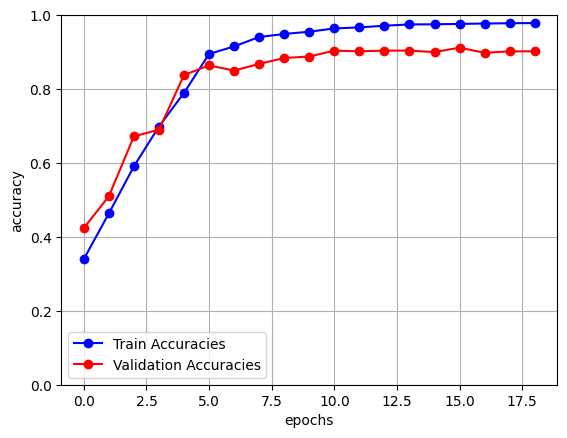

In [26]:
plt.figure()
plt.plot(range(len(train_acc)), train_acc, marker='o', color='b', label='Train Accuracies')
plt.plot(range(len(validation_acc)), validation_acc, marker='o', color='r', label='Validation Accuracies')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

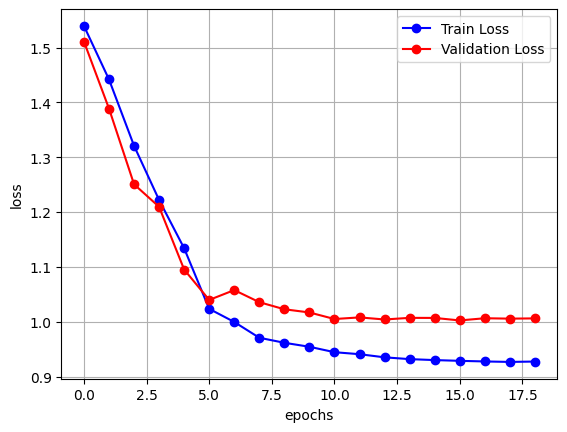

In [27]:
plt.figure()
plt.plot(range(len(train_loss)), train_loss, marker='o', color='b', label='Train Loss')
plt.plot(range(len(validation_loss)), validation_loss, marker='o', color='r', label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()